# Sprawozdanie z laboratorium 7

***Autor: Adam Dąbkowski***

Celem siódmego laboratorium jest zaimplementowanie naiwnego klasyfikatora Bayesa. Dodatkowo należy wykorzystać stworzony algorytm do stworzenia i zbadania jakości klasyfikatorów dla zbioru danych ***Cardio Vascular Disease Detection***. Doświadczenia mają zostać przeprowadzone, uwzględniając, zarówno różne podziały na zbiór trenujący, walidacyjny i testowy, jak i różne uruchomienia k-krotnej walidacji krzyżowej (z różnymi podziałami na zbiór treningowy+walidacyjny i testowy) w celu późniejszej oceny, która metoda pomiaru (zbiór walidacyjny czy walidacja krzyżowa) lepiej odzwierciedla wyniki na zbiorach testowych.


## 0. Importowanie niezbędnych bibliotek

In [247]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

## 1. Przygotowanie danych

Dane, na których będziemy testowali naszą implementację naiwnego klasyfikatora Bayesa, jest zbiór ***Cardio Vascular Disease Detection***. Jak widać na poniższym listingu, wśród cech znajduje się pole ***id***, które w trakcie uczenia modelu jest niepotrzebne.

In [248]:
data = pd.read_csv('./data/cardio_train.csv', sep=';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [249]:
data.drop(["id"], axis=1, inplace=True)

In [250]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


W analizowanym przez nas zbiorze klasą jest pole ***cardio***. Mając to na uwadze, możemy podzielić nasze na dwa zbiory: zbiór ***X*** (przestrzeń wejść) i zbiór ***y*** (przestrzeń wyjść). Dodatkowo poprzez zastosowanie ***dropna*** usuwane są wiersze z brakującymi danymi.

In [251]:
data.dropna(inplace=True)

In [252]:
X = data.drop('cardio', axis=1)
y = data['cardio']

In [253]:
X.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,22469,1,155,69.0,130,80,2,2,0,0,1
1,14648,1,163,71.0,110,70,1,1,0,0,1
2,21901,1,165,70.0,120,80,1,1,0,0,1
3,14549,2,165,85.0,120,80,1,1,1,1,1
4,23393,1,155,62.0,120,80,1,1,0,0,1


In [254]:
X = X.values
y = y.values

## 2. Implementacja naiwnego klasyfikatora Bayesa

Głównym zadaniem siódmego laboratorium jest implementacja naiwnego klasyfikatora Bayesa. W tym celu stworzona została klasa ***NaiveBayesClassifier***.

Klasa ta zawiera cztery metody:
- ***fit()*** - metoda odpowiedzialna za trenowanie modelu
- ***calc_gaussian_probability()*** - metoda wyznaczająca prawdopodobieństwie wynikające z rozkładu Gaussa
- ***classify()*** - metoda klasyfikująca pojedynczą próbkę
- ***predict()*** - metoda przeprowadzająca klasyfikację dla każdej próbki w danym zestawie

In [255]:
class NaiveBayesClassifier:
    def __init__(self):
        self.X = None
        self.y = None
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes = np.unique(y)

        self.mean = np.zeros((len(self.classes), X.shape[1]))
        self.var = np.zeros((len(self.classes), X.shape[1]))
        self.priors = np.zeros(len(self.classes))

        for i, c in enumerate(self.classes):
            X_c = self.X[np.where(y == c)]
            self.mean[i, :] = X_c.mean(axis=0)
            self.var[i, :] = X_c.var(axis=0)
            self.priors[i] = X_c.shape[0] / X.shape[0]

    def calc_gaussian_probability(self, mean, var, x):
        var_eps = 1e-3
        return (1.0 / np.sqrt(2.0 * np.pi * var + var_eps)) * (np.exp(-((x - mean) ** 2 / (2 * var + var_eps))))

    def classify(self, x):
        posteriors = []

        for i, c in enumerate(self.classes):
            prior = self.priors[i]
            posterior = np.prod(self.calc_gaussian_probability(self.mean[i], self.var[i], x))

            posterior = posterior * prior
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        return [self.classify(x) for x in X]

## 3. Implementacja funkcji pomocniczych

Aby usprawnić analizę otrzymanych wyników, zaimplementowane zostały funkcje pomocnicze ***get_metrics()*** oraz ***plot_confusion_matrix()*** . Pierwsza z nich zwraca wyniki poszczególnych metryk takich jak: dokładność, precyzja, pełność i wynik $F_1$, druga natomiast wyznacza macierz pomyłek dla badanego zbioru.

In [256]:
def get_metrics(y_true, y_pred, printing=True):
    accuracy = round(metrics.accuracy_score(y_true, y_pred), 5)
    precision = round(metrics.precision_score(y_true, y_pred), 5)
    recall = round(metrics.recall_score(y_true, y_pred), 5)
    f1_score = round(metrics.f1_score(y_true, y_pred), 5)

    if printing:
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 score: ", f1_score)

    return [accuracy, precision, recall, f1_score]

In [257]:
def plot_confusion_matrix(y_true, y_pred, set_type="test"):
    cf_matrix = metrics.confusion_matrix(y_true, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, center=True, annot=labels, fmt="", cmap='viridis')
    plt.title(f"Confusion matrix for {set_type} set")
    plt.show()

Aby móc sprawnie badać wpływ wielkości zbiórów oraz współczynnika **k** w przypadku walidacji krzyżowej zaimplementowane zostały także dwie funkcje: ***simulate_standard()*** i ***simulate_cross_validation()*** . Chcąc natomiast w łatwy sposób prezentować i analizować rezultaty działania algorytmu dla poszczególnych przypadków, stworzona została prosta klasa ***Results***.

In [258]:
def simulate_standard(X, y, train_size=0.7):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=train_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

    bayes_clf = NaiveBayesClassifier()
    bayes_clf.fit(X_train, y_train)

    y_val_pred = bayes_clf.predict(X_val)
    metrics_data_val = get_metrics(y_val, y_val_pred)
    plot_confusion_matrix(y_val, y_val_pred, set_type="validation")

    y_test_pred = bayes_clf.predict(X_test)
    metrics_data_test = get_metrics(y_test, y_test_pred)
    plot_confusion_matrix(y_test, y_test_pred, set_type = "test")

    return metrics_data_val, metrics_data_test

In [259]:
def simulate_cross_validation(X, y, train_size=0.6, k=3, print_matrix=True, print_deep=True):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=train_size, random_state=42)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    bayes_clf = NaiveBayesClassifier()

    metrics_data_val = []
    metrics_data_test = []

    i = 1

    for train_index, val_index in kf.split(X_train_val):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        bayes_clf.fit(X_train, y_train)

        if print_deep:
            print(f"Fold {i}")

        if print_deep:
            print(f"\n------- Validation set -------")

        y_pred_val = bayes_clf.predict(X_val)
        metrics_data_val.append(get_metrics(y_val, y_pred_val, printing=print_deep))

        if print_deep:
            print(f"\n------- Test set -------")
        y_pred_test = bayes_clf.predict(X_test)
        metrics_data_test.append(get_metrics(y_test, y_pred_test, printing=print_deep))

        if print_matrix:
            plot_confusion_matrix(y_val, y_pred_val, set_type = "validation")
            plot_confusion_matrix(y_test, y_pred_test, set_type = "test")

        i += 1

    metrics_data_val = np.array(metrics_data_val)
    average_accuracy_val = round(np.mean(metrics_data_val[:, 0]), 5)
    average_precision_val = round(np.mean(metrics_data_val[:, 1]), 5)
    average_recall_val = round(np.mean(metrics_data_val[:, 2]), 5)
    average_f1_score_val = round(np.mean(metrics_data_val[:, 3]), 5)

    metrics_data_test = np.array(metrics_data_test)
    average_accuracy_test = round(np.mean(metrics_data_test[:, 0]), 5)
    average_precision_test = round(np.mean(metrics_data_test[:, 1]), 5)
    average_recall_test = round(np.mean(metrics_data_test[:, 2]), 5)
    average_f1_score_test = round(np.mean(metrics_data_test[:, 3]), 5)


    print(f"-------------------- Average results ({k} folds)  --------------------")
    print(f"\n------- Validation set -------")
    print("Average accuracy:", average_accuracy_val)
    print("Average precision:", average_precision_val)
    print("Average recall:", average_recall_val)
    print("Average f1 score:", average_f1_score_val)

    print(f"\n------- Test set -------")
    print("Average accuracy:", average_accuracy_test)
    print("Average precision:", average_precision_test)
    print("Average recall:", average_recall_test)
    print("Average f1 score:", average_f1_score_test)

    return [average_accuracy_val, average_precision_val, average_recall_val, average_f1_score_val], [average_accuracy_test, average_precision_test, average_recall_test, average_f1_score_test]

In [260]:
class Results:
    def __init__(self):
        self.results = pd.DataFrame(columns=["Type", "Sets size (training|validation|test)", "Folds number", "Precision (test set)", "Recall (test set)", "F1 score (test set)", "Accuracy (test set)", "Accuracy (validation set)"])

    def update_results(self, type, size, folds, precision_test, recall_test, f1_score_test, accuracy_test, accuracy_val):
        self.results.loc[len(self.results)] = [type, size, folds, precision_test, recall_test, f1_score_test, accuracy_test, accuracy_val]

    def delete_row(self, index):
        self.results.drop([index], axis=0, inplace=True)

    def sort_results(self, column_name):
        self.results = self.results.sort_values(by=[column_name])

    def __repr__(self):
        return self.results.to_string()

## 4. Zastosowanie klasyfikatora

Po zaimplenetowaniu klasyfikatora możemy przejść do jego wykorzystania. Polega ono na stworzeniu i zbadaniu jakości dla zbioru danych ***Cardio Vascular Disease Detection*** . Należy sprawdzić jakość zarówno różnymi podziałami na zbiór trenujący, walidacyjny i testowy, jak i różnymi uruchomieniami k-krotnej walidacji krzyżowej, także w różnej konfiguracji oraz zbadać, która metoda pomiaru (zbiór walidacyjny czy walidacja krzyżowa) lepiej odzwierciedla wyniki na zbiorach testowych.

#### 4.1 Podział na zbiór trenujący, walidacyjny i testowy

Na początku rozważmy klasyczny podział na zbiór trenujący, walidacyjny i testowy. Pierwszy z badanych podziałów umożliwi uzyskanie zbioru trenującego, zawierającego **60%** danych, a także walidacyjnego i testowego, gdzie każdy z nich posiadać będzie po **20%** danych.

In [261]:
results_standard = Results()

Accuracy:  0.57633
Precision:  0.73087
Recall:  0.25165
F1 score:  0.37439


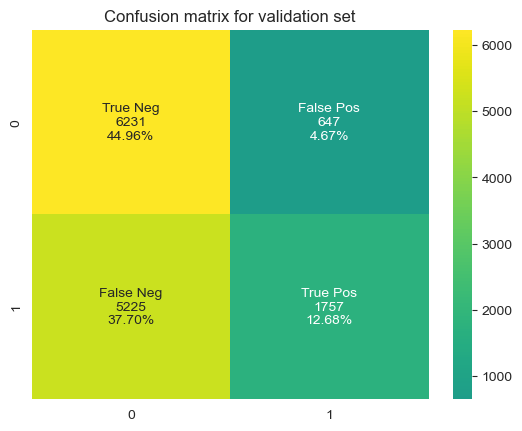

Accuracy:  0.57947
Precision:  0.72139
Recall:  0.25765
F1 score:  0.3797


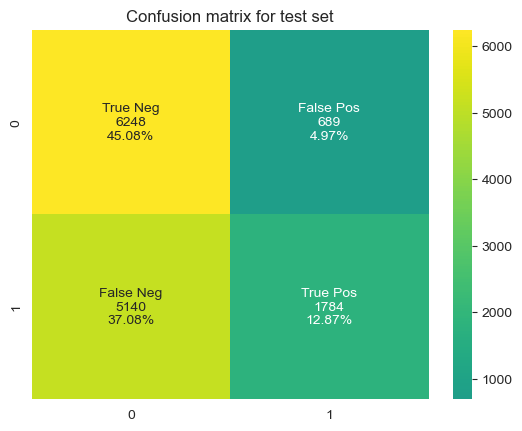

In [262]:
result = simulate_standard(X, y, train_size=0.6)

In [263]:
results_standard.update_results("Standard", "0,6  | 0,2   |   0,2", " ----- ", result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Zarówno na zbiorze walidacyjnym jak i testowym osiągnęliśmy zbliżoną nie tylko dokładność ale i wynik $F_1$. Oczywiście można dostrzec, że wspomniane wyniki na zbiorze testowym są minimalnie wyższe, jednakże różnica ta jest bardzo mała. Dzięki wykorzystaniu macierzy pomyłek, widzimy również, że uzyskujemy podobny rozkład w prawidłowym, jak i fałszywym rozpoznaniu próbek. Dodatkowo, nasz klasyfikator cechuje się znacznie większą precyzją niż pełnością, na co wskazuje nie tylko wyświetlony wynik, lecz również pole ***False Neg*** na wyświetlonej macierzy.

Nie znając wyników dla innych podziałów, nie jesteśmy w stanie precyzyjnie określić, czy charakter otrzymanych wyników spowodowany jest specyfiką samego klasyfikatora, czy być może decydujący wpływ wywiera stosunek pomiędzy wielkościami zbiorów. W związku z tym przeprowadzone zostały doświadczenia dla różnych rozmiarów zbiórów, gdzie zbiór treningowy stanowić będzie kolejno ***0,7*** , ***0,8*** , ***0,9***, ***0,95*** wszystkich danych, natomiast zbiory walidacyjny i testowy odpowiednio po ***0,15*** , ***0,1*** , ***0,05*** , ***0,025***.

Accuracy:  0.58461
Precision:  0.72203
Recall:  0.27449
F1 score:  0.39777


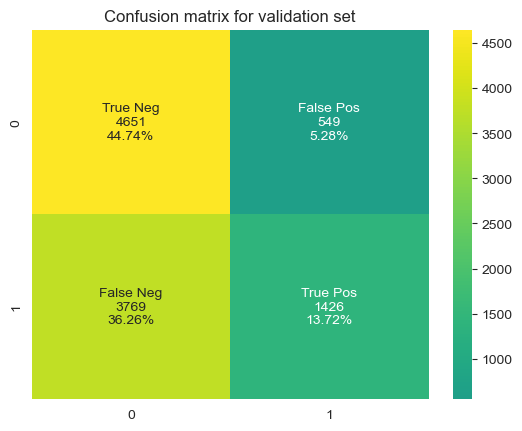

Accuracy:  0.58042
Precision:  0.7208
Recall:  0.26933
F1 score:  0.39214


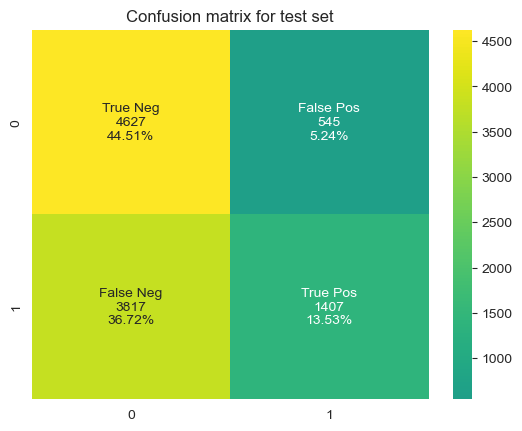

In [264]:
result = simulate_standard(X, y, train_size=0.7)

In [265]:
results_standard.update_results("Standard", "0,7  | 0,15  |  0,15", " ----- ", result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Accuracy:  0.58211
Precision:  0.72339
Recall:  0.26822
F1 score:  0.39134


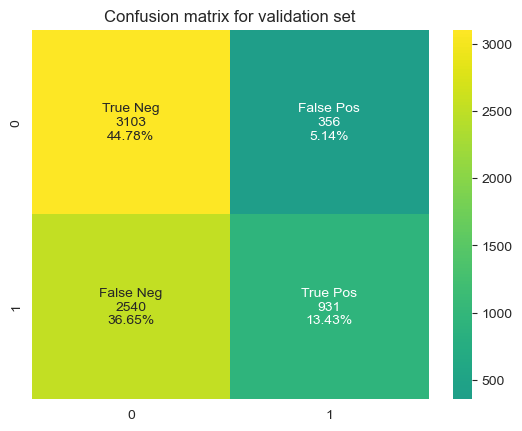

Accuracy:  0.58419
Precision:  0.7182
Recall:  0.27294
F1 score:  0.39555


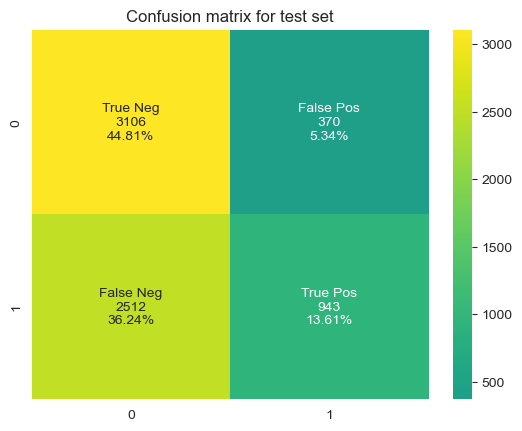

In [266]:
result = simulate_standard(X, y, train_size=0.8)

In [267]:
results_standard.update_results("Standard", "0,8  | 0,1   |   0,1", " ----- ", result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Accuracy:  0.58788
Precision:  0.69467
Recall:  0.30291
F1 score:  0.42186


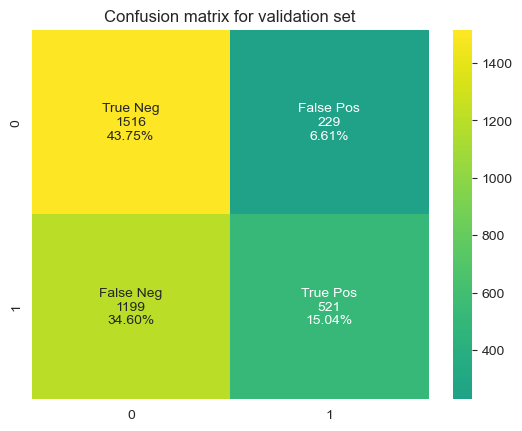

Accuracy:  0.58223
Precision:  0.69717
Recall:  0.29753
F1 score:  0.41707


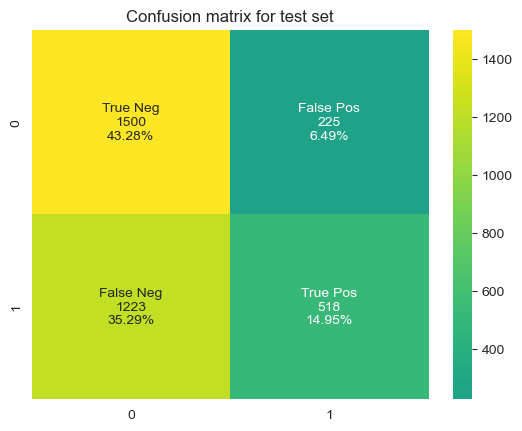

In [268]:
result = simulate_standard(X, y, train_size=0.9)

In [269]:
results_standard.update_results("Standard", "0,9  | 0,05  |  0,05", " ----- ", result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Accuracy:  0.57703
Precision:  0.69713
Recall:  0.30204
F1 score:  0.42147


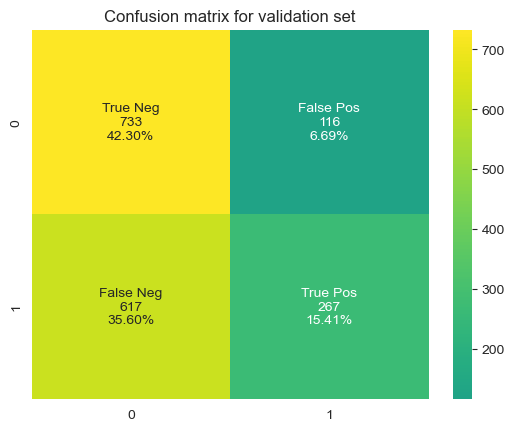

Accuracy:  0.58165
Precision:  0.70604
Recall:  0.30499
F1 score:  0.42597


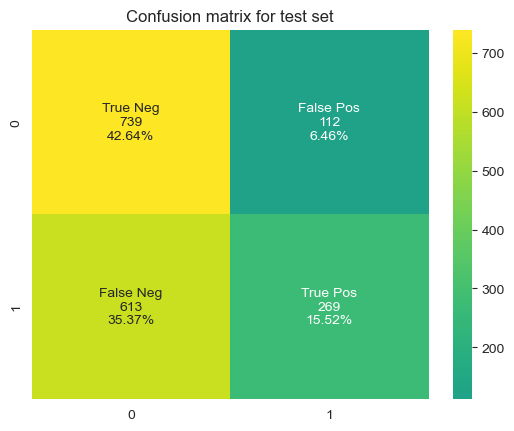

In [270]:
result = simulate_standard(X, y, train_size=0.95)

In [271]:
results_standard.update_results("Standard", "0,95 | 0,025 | 0,025", " ----- ", result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Poniżej zamieszona została zbiorcza tabela zawierająca wyniki dotychczasowych doświadczeń.

In [272]:
results_standard.sort_results("Sets size (training|validation|test)")
results_standard.results

,Type,Sets size (training|validation|test),Folds number,Precision (test set),Recall (test set),F1 score (test set),Accuracy (test set),Accuracy (validation set)
0,Standard,"0,6 | 0,2 | 0,2",-----,0.72139,0.25765,0.37970,0.57947,0.57633
1,Standard,"0,7 | 0,15 | 0,15",-----,0.72080,0.26933,0.39214,0.58042,0.58461
2,Standard,"0,8 | 0,1 | 0,1",-----,0.71820,0.27294,0.39555,0.58419,0.58211
3,Standard,"0,9 | 0,05 | 0,05",-----,0.69717,0.29753,0.41707,0.58223,0.58788
4,Standard,"0,95 | 0,025 | 0,025",-----,0.70604,0.30499,0.42597,0.58165,0.57703


Jak widać powyżej wielkość zbiorów nie wpływa znacząco na uzyskaną dokładność, jednakże nie można nie wspomnieć, że największość wartość wspomnianej metryki dostajemy dla podziałów ***1, 2, 3***, co jest spowodowane dostatecznie obszernym zbiorem trenującym, jednakże pozostawiającym na tyle dużo próbek wykorzystywanych w zbiorze walidacyjnym i testowym, że otrzymane wyniki są miarodajne jeśli chodzi o uzyskaną jakość klasyfikatora, ponieważ jednocześnie wskazują na uniezależnienie od czynników losowych podczas podziału, o czym świadczą porównywalne rezultaty dla zbiorów walidacyjnym i testowym. Jedyną próbą, w której w przypadku żadnego zbioru dokładność nie przekroczyła **58%** jest podział **0**. W jego przypadku zbiór trenujący jest zbyt mały przez co nie jest w stanie dostosować się do większej ilości przypadków, jednakże warto zaznaczyć, że dzięki takiemu podziałowi jesteśmy w stanie ocenić ze znacznie większą pewnością niż np. w podziale **4**, gdzie wielkość zbiorów walidacyjnego i testowego stanowi jedynie niewielki ułamek tego co zawiera zbiór trenujący.

#### 4.2 k-krotna walidacja krzyżowa

In [273]:
results_cross_validation = Results()

#### 4.2.1 Podział (0,6 | 0,4)

Fold 1

------- Validation set -------
Accuracy:  0.58261
Precision:  0.75853
Recall:  0.24362
F1 score:  0.36879

------- Test set -------
Accuracy:  0.5854
Precision:  0.76511
Recall:  0.2504
F1 score:  0.37731


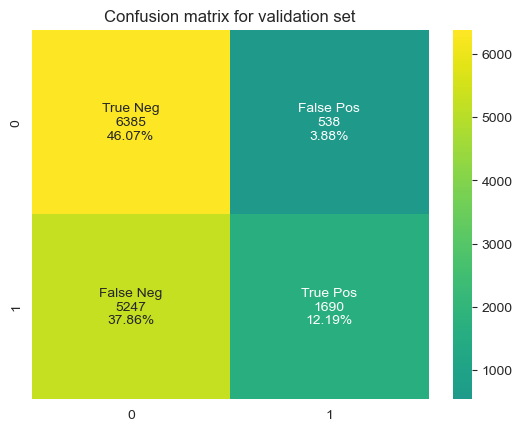

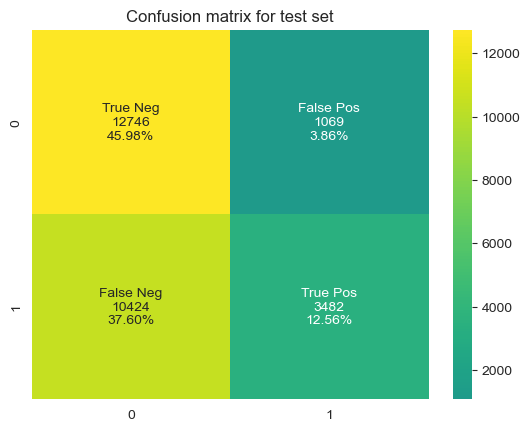

Fold 2

------- Validation set -------
Accuracy:  0.59481
Precision:  0.77749
Recall:  0.26037
F1 score:  0.3901

------- Test set -------
Accuracy:  0.59064
Precision:  0.77236
Recall:  0.26082
F1 score:  0.38996


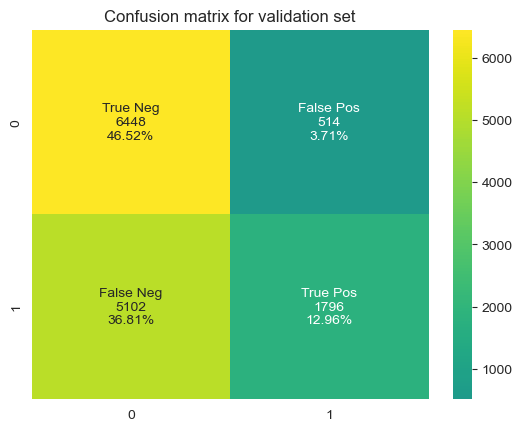

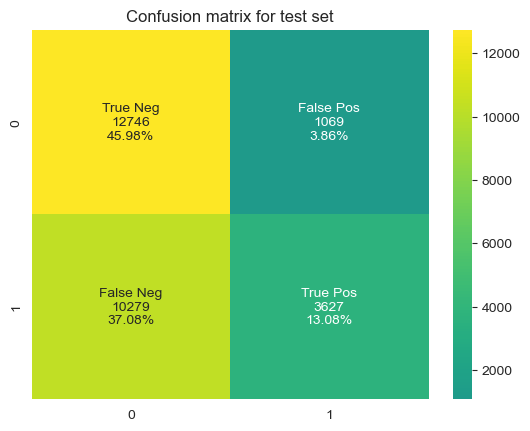

Fold 3

------- Validation set -------
Accuracy:  0.5956
Precision:  0.77735
Recall:  0.26433
F1 score:  0.39451

------- Test set -------
Accuracy:  0.5897
Precision:  0.76709
Recall:  0.26147
F1 score:  0.39


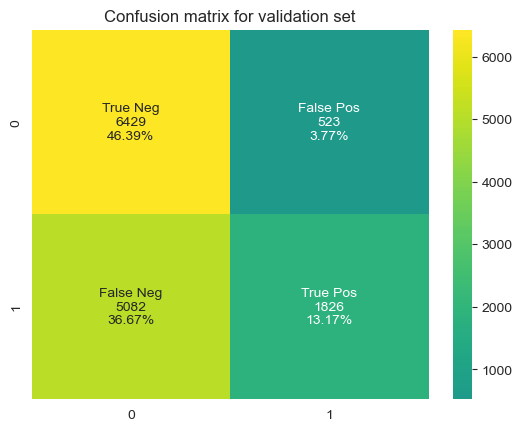

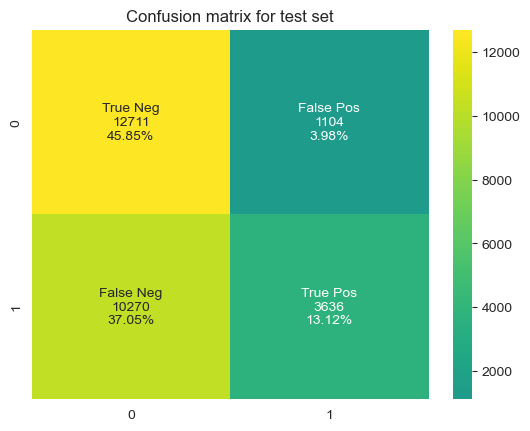

-------------------- Average results (3 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59101
Average precision: 0.77112
Average recall: 0.25611
Average f1 score: 0.38447

------- Test set -------
Average accuracy: 0.58858
Average precision: 0.76819
Average recall: 0.25756
Average f1 score: 0.38576


In [274]:
result = simulate_cross_validation(X, y, train_size=0.6, k=3)

In [275]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 3, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Fold 1

------- Validation set -------
Accuracy:  0.5898
Precision:  0.7561
Recall:  0.25301
F1 score:  0.37915

------- Test set -------
Accuracy:  0.58793
Precision:  0.76275
Recall:  0.25917
F1 score:  0.38688


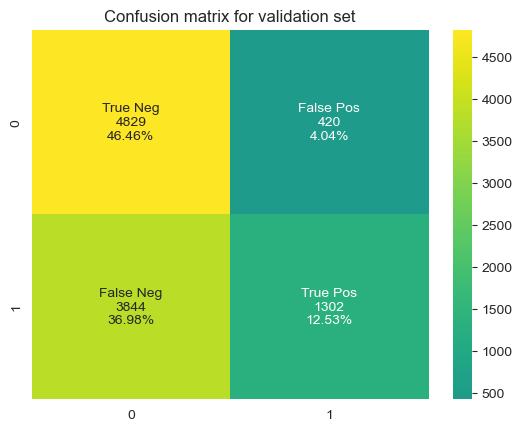

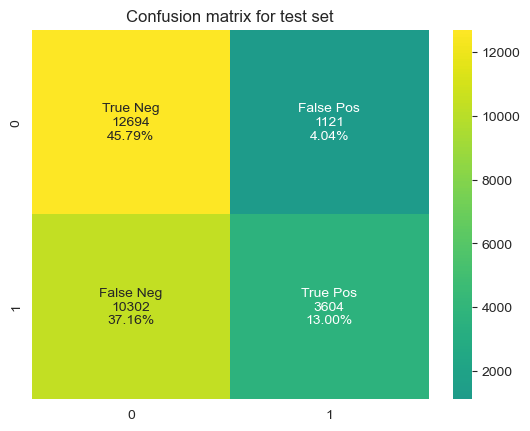

Fold 2

------- Validation set -------
Accuracy:  0.58692
Precision:  0.77665
Recall:  0.24966
F1 score:  0.37786

------- Test set -------
Accuracy:  0.58533
Precision:  0.77108
Recall:  0.24658
F1 score:  0.37367


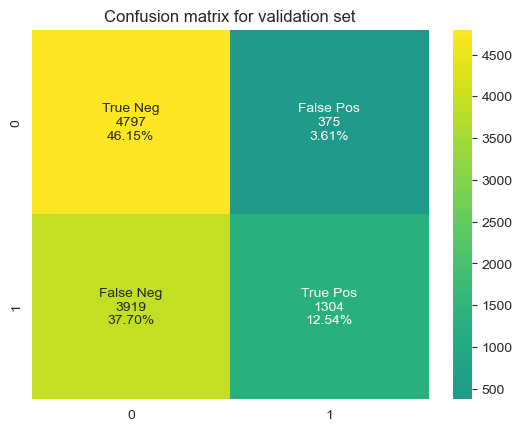

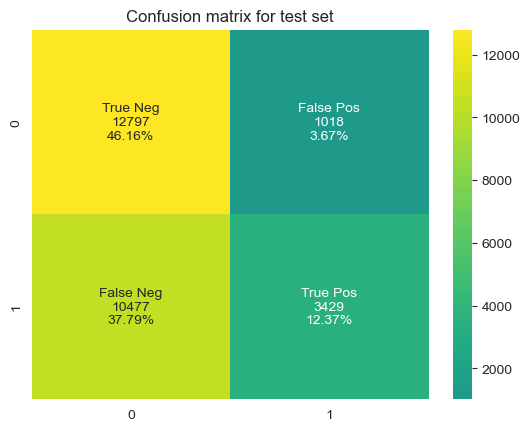

Fold 3

------- Validation set -------
Accuracy:  0.58788
Precision:  0.77531
Recall:  0.2487
F1 score:  0.3766

------- Test set -------
Accuracy:  0.58555
Precision:  0.7679
Recall:  0.2491
F1 score:  0.37617


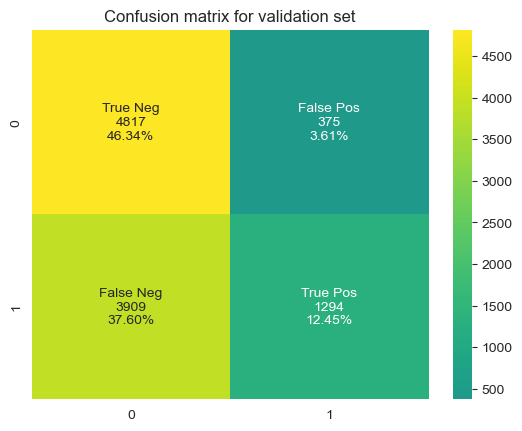

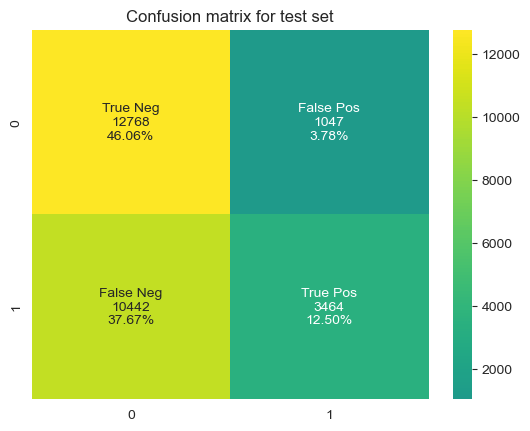

Fold 4

------- Validation set -------
Accuracy:  0.59557
Precision:  0.77087
Recall:  0.2661
F1 score:  0.39563

------- Test set -------
Accuracy:  0.59042
Precision:  0.76418
Recall:  0.26542
F1 score:  0.394


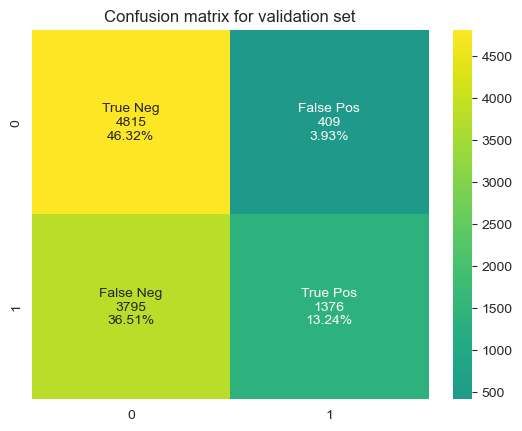

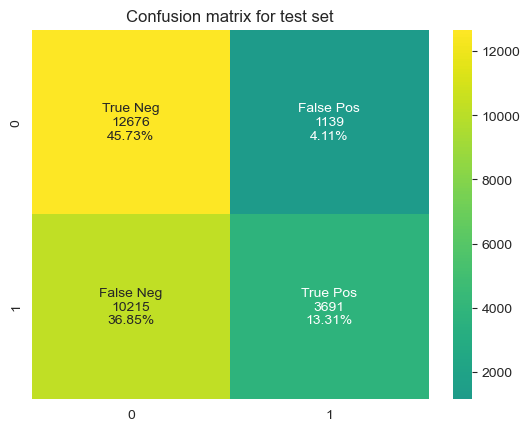

-------------------- Average results (4 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59004
Average precision: 0.76973
Average recall: 0.25437
Average f1 score: 0.38231

------- Test set -------
Average accuracy: 0.58731
Average precision: 0.76648
Average recall: 0.25507
Average f1 score: 0.38268


In [276]:
result = simulate_cross_validation(X, y, train_size=0.6, k=4)

In [277]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 4, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [278]:
result = simulate_cross_validation(X, y, train_size=0.6, k=5, print_matrix=False, print_deep=False)

-------------------- Average results (5 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59043
Average precision: 0.77
Average recall: 0.25538
Average f1 score: 0.38347

------- Test set -------
Average accuracy: 0.58802
Average precision: 0.76714
Average recall: 0.25661
Average f1 score: 0.38444


In [279]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 5, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [280]:
result = simulate_cross_validation(X, y, train_size=0.6, k=6, print_matrix=False, print_deep=False)

-------------------- Average results (6 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59021
Average precision: 0.76996
Average recall: 0.25471
Average f1 score: 0.38265

------- Test set -------
Average accuracy: 0.58795
Average precision: 0.76766
Average recall: 0.25611
Average f1 score: 0.384


In [281]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 6, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [282]:
result = simulate_cross_validation(X, y, train_size=0.6, k=8, print_matrix=False, print_deep=False)

-------------------- Average results (8 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59045
Average precision: 0.77089
Average recall: 0.2549
Average f1 score: 0.38303

------- Test set -------
Average accuracy: 0.58789
Average precision: 0.76769
Average recall: 0.25591
Average f1 score: 0.38376


In [283]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 8, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [284]:
result = simulate_cross_validation(X, y, train_size=0.6, k=10, print_matrix=False, print_deep=False)

-------------------- Average results (10 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59067
Average precision: 0.77111
Average recall: 0.25501
Average f1 score: 0.38318

------- Test set -------
Average accuracy: 0.58787
Average precision: 0.76755
Average recall: 0.25595
Average f1 score: 0.3838


In [285]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 10, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [286]:
result = simulate_cross_validation(X, y, train_size=0.6, k=20, print_matrix=False, print_deep=False)

-------------------- Average results (20 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59069
Average precision: 0.77188
Average recall: 0.25479
Average f1 score: 0.3829

------- Test set -------
Average accuracy: 0.58784
Average precision: 0.76788
Average recall: 0.25567
Average f1 score: 0.38358


In [287]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 20, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

#### 4.2.2 Podział (0,7 | 0,3)

In [288]:
result = simulate_cross_validation(X, y, train_size=0.7, k=3, print_matrix=False, print_deep=False)

-------------------- Average results (3 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59077
Average precision: 0.73674
Average recall: 0.28259
Average f1 score: 0.40764

------- Test set -------
Average accuracy: 0.58756
Average precision: 0.72815
Average recall: 0.28493
Average f1 score: 0.40837


In [289]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 3, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [290]:
result = simulate_cross_validation(X, y, train_size=0.7, k=4, print_matrix=False, print_deep=False)

-------------------- Average results (4 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58994
Average precision: 0.73353
Average recall: 0.28244
Average f1 score: 0.40701

------- Test set -------
Average accuracy: 0.5868
Average precision: 0.72434
Average recall: 0.28532
Average f1 score: 0.40835


In [291]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 4, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [292]:
result = simulate_cross_validation(X, y, train_size=0.7, k=5, print_matrix=False, print_deep=False)

-------------------- Average results (5 folds)  --------------------

------- Validation set -------
Average accuracy: 0.5892
Average precision: 0.73142
Average recall: 0.28192
Average f1 score: 0.40596

------- Test set -------
Average accuracy: 0.58636
Average precision: 0.72366
Average recall: 0.28423
Average f1 score: 0.40708


In [293]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 5, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [294]:
result = simulate_cross_validation(X, y, train_size=0.7, k=6, print_matrix=False, print_deep=False)

-------------------- Average results (6 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58862
Average precision: 0.73098
Average recall: 0.27956
Average f1 score: 0.40382

------- Test set -------
Average accuracy: 0.58553
Average precision: 0.72247
Average recall: 0.28194
Average f1 score: 0.4049


In [295]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 6, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [296]:
result = simulate_cross_validation(X, y, train_size=0.7, k=8, print_matrix=False, print_deep=False)

-------------------- Average results (8 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58776
Average precision: 0.7291
Average recall: 0.27768
Average f1 score: 0.40195

------- Test set -------
Average accuracy: 0.58475
Average precision: 0.72136
Average recall: 0.27999
Average f1 score: 0.40301


In [297]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 8, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [298]:
result = simulate_cross_validation(X, y, train_size=0.7, k=10, print_matrix=False, print_deep=False)

-------------------- Average results (10 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58724
Average precision: 0.72817
Average recall: 0.27717
Average f1 score: 0.40115

------- Test set -------
Average accuracy: 0.58447
Average precision: 0.72042
Average recall: 0.27991
Average f1 score: 0.40275


In [299]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 10, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [300]:
result = simulate_cross_validation(X, y, train_size=0.7, k=20, print_matrix=False, print_deep=False)

-------------------- Average results (20 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58635
Average precision: 0.7256
Average recall: 0.27611
Average f1 score: 0.39976

------- Test set -------
Average accuracy: 0.58396
Average precision: 0.71947
Average recall: 0.27868
Average f1 score: 0.40156


In [301]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 20, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

#### 4.2.3 Podział (0,8 | 0,2)

In [302]:
result = simulate_cross_validation(X, y, train_size=0.8, k=3, print_matrix=False, print_deep=False)

-------------------- Average results (3 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58934
Average precision: 0.72327
Average recall: 0.28745
Average f1 score: 0.41138

------- Test set -------
Average accuracy: 0.58723
Average precision: 0.71291
Average recall: 0.29122
Average f1 score: 0.41349


In [303]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 3, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [304]:
result = simulate_cross_validation(X, y, train_size=0.8, k=4, print_matrix=False, print_deep=False)

-------------------- Average results (4 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59051
Average precision: 0.72104
Average recall: 0.29316
Average f1 score: 0.41592

------- Test set -------
Average accuracy: 0.58801
Average precision: 0.71178
Average recall: 0.29559
Average f1 score: 0.41682


In [305]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 4, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [306]:
result = simulate_cross_validation(X, y, train_size=0.8, k=5, print_matrix=False, print_deep=False)

-------------------- Average results (5 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58943
Average precision: 0.72135
Average recall: 0.28981
Average f1 score: 0.41333

------- Test set -------
Average accuracy: 0.58739
Average precision: 0.71121
Average recall: 0.29347
Average f1 score: 0.41542


In [307]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 5, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [308]:
result = simulate_cross_validation(X, y, train_size=0.8, k=6, print_matrix=False, print_deep=False)

-------------------- Average results (6 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59013
Average precision: 0.71935
Average recall: 0.2934
Average f1 score: 0.41606

------- Test set -------
Average accuracy: 0.588
Average precision: 0.71048
Average recall: 0.29652
Average f1 score: 0.41779


In [309]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 6, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [310]:
result = simulate_cross_validation(X, y, train_size=0.8, k=8, print_matrix=False, print_deep=False)

-------------------- Average results (8 folds)  --------------------

------- Validation set -------
Average accuracy: 0.5897
Average precision: 0.71955
Average recall: 0.29213
Average f1 score: 0.41512

------- Test set -------
Average accuracy: 0.58774
Average precision: 0.71021
Average recall: 0.29584
Average f1 score: 0.41727


In [311]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 8, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [312]:
result = simulate_cross_validation(X, y, train_size=0.8, k=10, print_matrix=False, print_deep=False)

-------------------- Average results (10 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58959
Average precision: 0.71917
Average recall: 0.29201
Average f1 score: 0.41491

------- Test set -------
Average accuracy: 0.58788
Average precision: 0.71041
Average recall: 0.29603
Average f1 score: 0.41752


In [313]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 10, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [314]:
result = simulate_cross_validation(X, y, train_size=0.8, k=20, print_matrix=False, print_deep=False)

-------------------- Average results (20 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58932
Average precision: 0.71929
Average recall: 0.29105
Average f1 score: 0.41408

------- Test set -------
Average accuracy: 0.58795
Average precision: 0.7106
Average recall: 0.29596
Average f1 score: 0.4177


In [315]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 20, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

#### 4.2.4 Podział (0,9 | 0,1)

In [316]:
result = simulate_cross_validation(X, y, train_size=0.9, k=3, print_matrix=False, print_deep=False)

-------------------- Average results (3 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59399
Average precision: 0.73155
Average recall: 0.2998
Average f1 score: 0.42112

------- Test set -------
Average accuracy: 0.58659
Average precision: 0.70582
Average recall: 0.29991
Average f1 score: 0.4168


In [317]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 3, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [318]:
result = simulate_cross_validation(X, y, train_size=0.9, k=4, print_matrix=False, print_deep=False)

-------------------- Average results (4 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59187
Average precision: 0.72952
Average recall: 0.29258
Average f1 score: 0.41601

------- Test set -------
Average accuracy: 0.58484
Average precision: 0.70608
Average recall: 0.29132
Average f1 score: 0.41073


In [319]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 4, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [320]:
result = simulate_cross_validation(X, y, train_size=0.9, k=5, print_matrix=False, print_deep=False)

-------------------- Average results (5 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59197
Average precision: 0.7284
Average recall: 0.29288
Average f1 score: 0.41664

------- Test set -------
Average accuracy: 0.58511
Average precision: 0.70562
Average recall: 0.29188
Average f1 score: 0.41179


In [321]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 5, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [322]:
result = simulate_cross_validation(X, y, train_size=0.9, k=6, print_matrix=False, print_deep=False)

-------------------- Average results (6 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58993
Average precision: 0.72082
Average recall: 0.29166
Average f1 score: 0.4147

------- Test set -------
Average accuracy: 0.5837
Average precision: 0.70001
Average recall: 0.29148
Average f1 score: 0.41097


In [323]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 6, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [324]:
result = simulate_cross_validation(X, y, train_size=0.9, k=8, print_matrix=False, print_deep=False)

-------------------- Average results (8 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58966
Average precision: 0.72119
Average recall: 0.29015
Average f1 score: 0.41356

------- Test set -------
Average accuracy: 0.58338
Average precision: 0.69985
Average recall: 0.29038
Average f1 score: 0.41011


In [325]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 8, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [326]:
result = simulate_cross_validation(X, y, train_size=0.9, k=10, print_matrix=False, print_deep=False)

-------------------- Average results (10 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58958
Average precision: 0.72084
Average recall: 0.29006
Average f1 score: 0.41348

------- Test set -------
Average accuracy: 0.58345
Average precision: 0.69996
Average recall: 0.29041
Average f1 score: 0.41027


In [327]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 10, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [328]:
result = simulate_cross_validation(X, y, train_size=0.9, k=20, print_matrix=False, print_deep=False)

-------------------- Average results (20 folds)  --------------------

------- Validation set -------
Average accuracy: 0.58931
Average precision: 0.7194
Average recall: 0.29028
Average f1 score: 0.41346

------- Test set -------
Average accuracy: 0.58318
Average precision: 0.69892
Average recall: 0.29048
Average f1 score: 0.41023


In [329]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 20, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

#### 4.2.5 Podział (0,95 | 0,05)

In [330]:
result = simulate_cross_validation(X, y, train_size=0.95, k=3, print_matrix=False, print_deep=False)

-------------------- Average results (3 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59271
Average precision: 0.72213
Average recall: 0.30074
Average f1 score: 0.42411

------- Test set -------
Average accuracy: 0.57982
Average precision: 0.71145
Average recall: 0.29539
Average f1 score: 0.41704


In [331]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 3, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [332]:
result = simulate_cross_validation(X, y, train_size=0.95, k=4, print_matrix=False, print_deep=False)

-------------------- Average results (4 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59123
Average precision: 0.72186
Average recall: 0.29612
Average f1 score: 0.41935

------- Test set -------
Average accuracy: 0.57819
Average precision: 0.71064
Average recall: 0.29077
Average f1 score: 0.41222


In [333]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 4, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [334]:
result = simulate_cross_validation(X, y, train_size=0.95, k=5, print_matrix=False, print_deep=False)

-------------------- Average results (5 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59093
Average precision: 0.721
Average recall: 0.29631
Average f1 score: 0.41931

------- Test set -------
Average accuracy: 0.57813
Average precision: 0.70992
Average recall: 0.29128
Average f1 score: 0.41263


In [335]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 5, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [336]:
result = simulate_cross_validation(X, y, train_size=0.95, k=6, print_matrix=False, print_deep=False)

-------------------- Average results (6 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59095
Average precision: 0.72102
Average recall: 0.29616
Average f1 score: 0.41933

------- Test set -------
Average accuracy: 0.57833
Average precision: 0.71071
Average recall: 0.29115
Average f1 score: 0.41268


In [337]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 6, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [338]:
result = simulate_cross_validation(X, y, train_size=0.95, k=8, print_matrix=False, print_deep=False)

-------------------- Average results (8 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59057
Average precision: 0.72068
Average recall: 0.29535
Average f1 score: 0.41862

------- Test set -------
Average accuracy: 0.57866
Average precision: 0.71087
Average recall: 0.2919
Average f1 score: 0.41365


In [339]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 8, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [340]:
result = simulate_cross_validation(X, y, train_size=0.95, k=10, print_matrix=False, print_deep=False)

-------------------- Average results (10 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59072
Average precision: 0.72092
Average recall: 0.29551
Average f1 score: 0.41887

------- Test set -------
Average accuracy: 0.5783
Average precision: 0.7099
Average recall: 0.29173
Average f1 score: 0.41331


In [341]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 10, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [342]:
result = simulate_cross_validation(X, y, train_size=0.95, k=20, print_matrix=False, print_deep=False)

-------------------- Average results (20 folds)  --------------------

------- Validation set -------
Average accuracy: 0.59096
Average precision: 0.72147
Average recall: 0.29581
Average f1 score: 0.41933

------- Test set -------
Average accuracy: 0.57809
Average precision: 0.70935
Average recall: 0.29142
Average f1 score: 0.41304


In [343]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 20, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [344]:
results_standard.sort_results("Sets size (training|validation|test)")
results_cross_validation.results

,Type,Sets size (training|validation|test),Folds number,Precision (test set),Recall (test set),F1 score (test set),Accuracy (test set),Accuracy (validation set)
0,Cross validation,"0,6 | 0,4",3,0.76819,0.25756,0.38576,0.58858,0.59101
1,Cross validation,"0,6 | 0,4",4,0.76648,0.25507,0.38268,0.58731,0.59004
2,Cross validation,"0,6 | 0,4",5,0.76714,0.25661,0.38444,0.58802,0.59043
3,Cross validation,"0,6 | 0,4",6,0.76766,0.25611,0.38400,0.58795,0.59021
4,Cross validation,"0,6 | 0,4",8,0.76769,0.25591,0.38376,0.58789,0.59045
5,Cross validation,"0,6 | 0,4",10,0.76755,0.25595,0.38380,0.58787,0.59067
6,Cross validation,"0,6 | 0,4",20,0.76788,0.25567,0.38358,0.58784,0.59069
7,Cross validation,"0,7 | 0,3",3,0.72815,0.28493,0.40837,0.58756,0.59077
8,Cross validation,"0,7 | 0,3",4,0.72434,0.28532,0.40835,0.58680,0.58994
9,Cross validation,"0,7 | 0,3",5,0.72366,0.28423,0.40708,0.58636,0.58920


## 5. Podsumowanie

In [345]:
results = pd.concat([results_standard.results, results_cross_validation.results])

In [346]:
results

,Type,Sets size (training|validation|test),Folds number,Precision (test set),Recall (test set),F1 score (test set),Accuracy (test set),Accuracy (validation set)
0,Standard,"0,6 | 0,2 | 0,2",-----,0.72139,0.25765,0.37970,0.57947,0.57633
1,Standard,"0,7 | 0,15 | 0,15",-----,0.72080,0.26933,0.39214,0.58042,0.58461
2,Standard,"0,8 | 0,1 | 0,1",-----,0.71820,0.27294,0.39555,0.58419,0.58211
3,Standard,"0,9 | 0,05 | 0,05",-----,0.69717,0.29753,0.41707,0.58223,0.58788
4,Standard,"0,95 | 0,025 | 0,025",-----,0.70604,0.30499,0.42597,0.58165,0.57703
0,Cross validation,"0,6 | 0,4",3,0.76819,0.25756,0.38576,0.58858,0.59101
1,Cross validation,"0,6 | 0,4",4,0.76648,0.25507,0.38268,0.58731,0.59004
2,Cross validation,"0,6 | 0,4",5,0.76714,0.25661,0.38444,0.58802,0.59043
3,Cross validation,"0,6 | 0,4",6,0.76766,0.25611,0.38400,0.58795,0.59021
4,Cross validation,"0,6 | 0,4",8,0.76769,0.25591,0.38376,0.58789,0.59045
